In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from log import *
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
# TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
# TransactionAMT: transaction payment amount in USD
# ProductCD: product code, the product for each transaction
# card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
# addr: address
# dist: distance
# P_ and (R__) emaildomain: purchaser and recipient email domain
# C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
# D1-D15: timedelta, such as days between previous transaction, etc.
# M1-M9: match, such as names on card and address, etc.
# Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [ ]:
# Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
# They're collected by Vesta’s fraud protection system and digital security partners.
# (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

# Categorical Features:
# DeviceType
# DeviceInfo
# id12 - id38

In [2]:
train = pd.read_pickle('data/train.pkl')

In [3]:
test = pd.read_pickle('data/test.pkl')

In [4]:
#convert ProductCD to individual features

for feature in train.ProductCD.unique().tolist():
    train[feature] = train['ProductCD'].str.contains(feature) #return t/f for new columns
train[train.ProductCD.unique().tolist()].head(5)

,W,H,C,S,R
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,False,True,False,False,False


In [5]:
def fix_missing_num(df, colname):
    df[colname+'_na'] = pd.isnull(df[colname])
    df[colname].fillna(df[colname].median(), inplace=True)

In [6]:
for col in train.filter(regex=('D\d')).columns:
    fix_missing_num(train, col)

In [7]:
train.filter(regex=('D\d')).columns

Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'D1_na', 'D2_na', 'D3_na', 'D4_na', 'D5_na',
       'D6_na', 'D7_na', 'D8_na', 'D9_na', 'D10_na', 'D11_na', 'D12_na',
       'D13_na', 'D14_na', 'D15_na'],
      dtype='object')

In [8]:
train['M4'] = train['M4'].fillna('')
for m in ['M0','M1','M2']:
    train[m+m]= train['M4'].str.contains(m)

In [9]:
for col in train.filter(regex='dist').columns:
    fix_missing_num(train,col)

In [10]:
train.filter(regex='dist')

,dist1,dist2,dist1_na,dist2_na
0,19.0,37.0,False,True
1,8.0,37.0,True,True
2,287.0,37.0,False,True
3,8.0,37.0,True,True
4,8.0,37.0,True,True
...,...,...,...,...
590535,48.0,37.0,False,True
590536,8.0,37.0,True,True
590537,8.0,37.0,True,True
590538,3.0,37.0,False,True


In [11]:
train.filter(regex=('M[^4]$')).iloc[:, :-3]

,M1,M2,M3,M5,M6,M7,M8,M9
0,T,T,T,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,T,T,NaN,NaN,NaN
2,T,T,T,F,F,F,F,F
3,NaN,NaN,NaN,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
590535,T,T,T,T,F,F,F,T
590536,T,F,F,F,T,F,F,F
590537,T,F,F,NaN,T,NaN,NaN,NaN
590538,T,T,T,F,T,NaN,NaN,NaN


In [12]:
for col in train.filter(regex=('M[^4]$')).iloc[:, :-3]:
    train[col+'_na'] = pd.isnull(train[col])
    train[col].fillna('False', inplace=True)

In [13]:
# standardize T and F to true and false
def fix_tf(row):
    if row == 'T' or row == 'True':
        return True
    elif row == 'F' or row == 'False':
        return False
    else:
        return row

In [14]:
for col in train.filter(regex=('M[^4]$')).iloc[:, :-3]:
    train[col] = train[col].map(fix_tf)
# for col in ['M7', 'M8', 'M9']:
#     train[col] = train[col].map(fix_tf)

In [16]:
train.filter(regex=('M'))

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M0M0,M1M1,M2M2,M1_na,M2_na,M3_na,M5_na,M6_na,M7_na,M8_na,M9_na
0,True,True,True,M2,False,True,False,False,False,False,False,True,False,False,False,False,False,True,True,True
1,False,False,False,M0,True,True,False,False,False,True,False,False,True,True,True,False,False,True,True,True
2,True,True,True,M0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,M0,True,False,False,False,False,True,False,False,True,True,True,False,False,True,True,True
4,False,False,False,,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,True,True,True,M0,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
590536,True,False,False,M0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
590537,True,False,False,,False,True,False,False,False,False,False,False,False,False,False,True,False,True,True,True
590538,True,True,True,M0,False,True,False,False,False,True,False,False,False,False,False,False,False,True,True,True


In [17]:
train.DeviceType.value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

In [18]:
train.DeviceType.unique()
train.DeviceType = train.DeviceType.fillna('')
for feature in train.DeviceType.unique():
    train[feature] = train.DeviceType.str.contains(feature)
# put 'desktop' or 'mobile' as feature

In [19]:
train.filter(regex=('card\d'))

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit
...,...,...,...,...,...,...
590535,6550,NaN,150.0,visa,226.0,debit
590536,10444,225.0,150.0,mastercard,224.0,debit
590537,12037,595.0,150.0,mastercard,224.0,debit
590538,7826,481.0,150.0,mastercard,224.0,debit


In [20]:
# convert card4 into boolean columns for each card type. one more for the nan as that might be predictive
train.card4.unique()
train.card4 = train.card4.fillna('other_card')
for feature in train.card4.unique():
    train[feature] = train.card4.str.contains(feature)

In [21]:
train.card6.unique()

array(['credit', 'debit', nan, 'debit or credit', 'charge card'],
      dtype=object)

In [22]:
# what to do about debit or credit... does that fall under nan?
train.card6 = train.card6.replace('debit or credit', np.nan)
train['card6_na'] = pd.isnull(train['card6'])
train.card6 = train.card6.fillna('')
for feature in train.card6.unique():
    train[feature] = train.card6.str.contains(feature)

In [23]:
train.card3.unique()
train.card5.unique()

array([142., 102., 166., 117., 226., 224., 134., 219., 137., 195., 138.,
       100., 147., 162., 202., 118., 150., 183., 171., 236., 197., 133.,
       223., 149., 228., 229.,  nan, 198., 182., 126., 185., 190., 131.,
       144., 141., 215., 203., 237., 132., 143., 146., 140., 129., 199.,
       194., 213., 111., 169., 177., 173., 156., 119., 135., 107., 232.,
       188., 159., 127., 148., 139., 104., 210., 180., 207., 204., 212.,
       106., 152., 222., 187., 200., 214., 189., 181., 206., 225., 157.,
       121., 217., 184., 167., 113., 136., 120., 201., 211., 122., 164.,
       123., 145., 172., 114., 231., 105., 221., 234., 130., 109., 196.,
       101., 158., 230., 128., 191., 165., 115., 233., 216., 116., 178.,
       125., 163., 205., 112., 168., 209., 235., 151., 175., 160.])

In [24]:
# card 2,3,5 columns are numbers that should be categories. this goes for some other columns that i should look for
def num_to_cat(df, col):
    df[col] = df[col].astype('category').cat.as_ordered()
    catencoders = {}
    catencoders[col] = df[col].cat.categories
    df[col] = train[col].cat.codes + 1

num_cat_features = ['card2','card3','card5', 'addr1', 'addr2']
for col in num_cat_features:
    num_to_cat(train, col)

def string_to_cat(df, colname):
    catencoders = {}
    df[colname] = df[colname].astype('category').cat.as_ordered()
    catencoders[colname] = df[colname].cat.categories
    df[colname] = df[colname].cat.codes + 1
            
str_cat_features = ['P_emaildomain', 'R_emaildomain', 'DeviceInfo']
for col in str_cat_features:
    string_to_cat(train, col)

In [31]:
bool_features = ['mobile', 'desktop', 'credit', 'debit', 'charge card', 'card6_na']
for feature in train.card4.unique():
    bool_features.append(feature)
print(bool_features)

num_features = ['TransactionAmt','dist1', 'dist2', 'M0M0', 'M1M1', 'M2M2']
#for col in train.filter(regex=('C\d')).columns:
#    num_features.append(col)
for col in train.filter(regex=('D\d')).columns:
    num_features.append(col)
for col in train.filter(regex='dist').columns:
    num_features.append(col)
for col in train.filter(regex=('M')).columns:
    num_features.append(col)
num_features.remove('M4')
print(num_features)

['mobile', 'desktop', 'credit', 'debit', 'charge card', 'card6_na', 'discover', 'mastercard', 'visa', 'american express', 'other_card']
['TransactionAmt', 'dist1', 'dist2', 'M0M0', 'M1M1', 'M2M2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D1_na', 'D2_na', 'D3_na', 'D4_na', 'D5_na', 'D6_na', 'D7_na', 'D8_na', 'D9_na', 'D10_na', 'D11_na', 'D12_na', 'D13_na', 'D14_na', 'D15_na', 'dist1', 'dist2', 'dist1_na', 'dist2_na', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'M0M0', 'M1M1', 'M2M2', 'M1_na', 'M2_na', 'M3_na', 'M5_na', 'M6_na', 'M7_na', 'M8_na', 'M9_na']


In [32]:
# bool_features
# num_features
from sklearn.model_selection import train_test_split
X = train[bool_features+num_features+num_cat_features+str_cat_features]
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print(f"RF Training score {rf.score(X_train, y_train):.4f}")
print(f"RF Validation score {rf.score(X_test, y_test):.4f}")


RF Training score 0.9999
RF Validation score 0.9772


In [42]:
y_pred = rf.predict(X_test)
accuracies = accuracy_score(y_test, y_pred)
precisions = precision_score(y_test, y_pred)
recalls = recall_score(y_test, y_pred)

print("accuracy:", np.average(accuracies))
print("precision:", np.average(precisions))
print("recall:", np.average(recalls))

accuracy: 0.9771819013106648
precision: 0.8978102189781022
recall: 0.38886186770428016


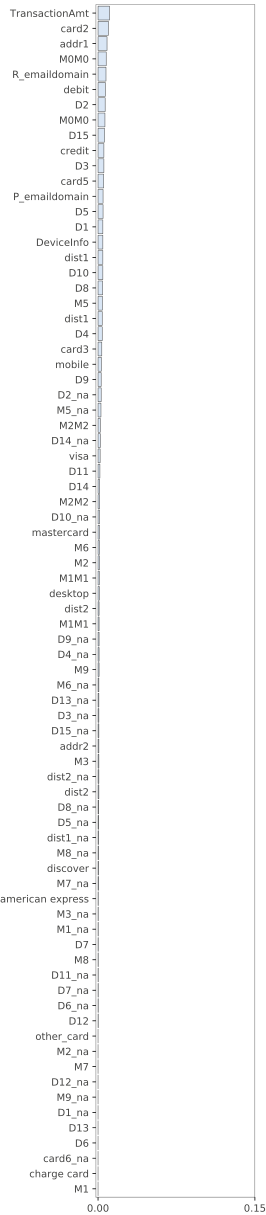

In [36]:
from rfpimp import *
I = importances(rf, X, y)
plot_importances(I)

In [34]:
# this score seems a bit high.. must have coded in the isfraud somehow
model = LogisticRegression()
model.fit(X_train, y_train)

/home/richard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
y_predict = model.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracies = accuracy_score(y_test, y_predict)
precisions = precision_score(y_test, y_predict)
recalls = recall_score(y_test, y_predict)

print("accuracy:", np.average(accuracies))
print("precision:", np.average(precisions))
print("recall:", np.average(recalls))

accuracy: 0.9656331493209604
precision: 0.6497175141242938
recall: 0.027966926070038912


Text(0.5, 1.0, 'ROC plot of fake data')

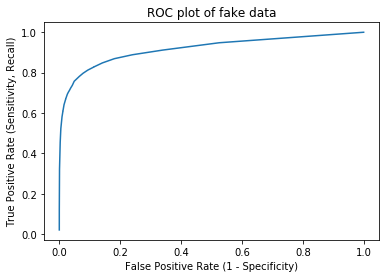

In [71]:
from log import *
probabilities = rf.predict_proba(X_test)[:, 1]

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")

# ROC plot for random forest

Text(0.5, 1.0, 'ROC plot of fake data')

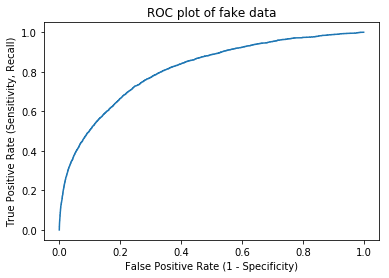

In [72]:
# ROC plot for logistic regression

probabilities = model.predict_proba(X_test)[:, 1]

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")

0

In [ ]:
#V1 - V339
#id_01 - id_38

In [ ]:
train_df.filter(regex=('..emaildomain'))

In [ ]:
train_df.R_emaildomain.unique()

In [ ]:
train_df.filter(regex=('addr'))

In [ ]:
train_df.addr1.value_counts()

In [ ]:
# train_df.addr2.value_counts()
temp = train_df.groupby('addr2')
temp.isFraud.value_counts(normalize=True)

In [ ]:
train_df.filter(regex=('Device'))

In [ ]:
train_df.filter(regex=('V\d'))

In [ ]:
train_df.filter(regex=('id'))

In [ ]:
train.id_31.unique()